#Imports

In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.5 MB/s eta 0:00:00


In [2]:
#basic
from pathlib import Path
import random
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from PIL import Image

#modeling
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import timm
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import OneCycleLR
import copy

%matplotlib inline

#Data loading

In [3]:
# Kaggle environment setup
!mkdir -p ~/.kaggle
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

100% 1.62G/1.62G [00:20<00:00, 105MB/s] 
100% 1.62G/1.62G [00:20<00:00, 85.4MB/s]


In [5]:
!unzip /content/ocular-disease-recognition-odir5k.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg

In [6]:
df_all = pd.read_csv('/content/full_df.csv')

In [7]:
df_all.sample(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
1361,2052,62,Male,2052_left.jpg,2052_right.jpg,hypertensive retinopathy，cataract,hypertensive retinopathy，cataract,0,0,0,1,0,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['H'],"[0, 0, 0, 0, 0, 1, 0, 0]",2052_right.jpg
1030,1263,62,Male,1263_left.jpg,1263_right.jpg,old central retinal vein occlusion,glaucoma，hypertensive retinopathy,0,0,1,0,0,1,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['G'],"[0, 0, 1, 0, 0, 0, 0, 0]",1263_right.jpg
3067,4538,44,Male,4538_left.jpg,4538_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4538_right.jpg
1183,1527,64,Female,1527_left.jpg,1527_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",1527_right.jpg
3175,4660,51,Male,4660_left.jpg,4660_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",4660_right.jpg


In [8]:
df_all['left_cataract'] = df_all['Left-Diagnostic Keywords'].apply(lambda x: 1 if 'cataract' in str(x).lower() else 0)
df_all['right_cataract'] = df_all['Right-Diagnostic Keywords'].apply(lambda x: 1 if 'cataract' in str(x).lower() else 0)

In [9]:
left_cataract = df_all[df_all['left_cataract'] == 1]['Left-Fundus'].values
right_cataract = df_all[df_all['right_cataract'] == 1]['Right-Fundus'].values
print(f'Number of images in left cataract: {len(left_cataract)}')
print(f'Number of images in right cataract: {len(right_cataract)}')

Number of images in left cataract: 304
Number of images in right cataract: 290


In [10]:
left_normal = df_all[(df_all['C']==0) & (df_all['Left-Diagnostic Keywords']=='normal fundus')]['Left-Fundus'].values
right_normal = df_all[(df_all['C']==0) & (df_all['Right-Diagnostic Keywords']=='normal fundus')]['Right-Fundus'].values
print(f'Number of images in left normal: {len(left_normal)}')
print(f'Number of images in right normal: {len(right_normal)}')

Number of images in left normal: 2748
Number of images in right normal: 2657


In [11]:
cataract = np.concatenate([left_cataract, right_cataract])
normal = np.concatenate([left_normal, right_normal])

In [12]:
cataract = pd.DataFrame(cataract, columns=['filename'])
normal = pd.DataFrame(normal, columns=['filename'])

In [13]:
cataract['label'] = 1
normal['label'] = 0

In [14]:
df_combined = pd.concat([cataract, normal])
df_combined.sample(10)

,filename,label
1279,4298_left.jpg,0
1460,511_left.jpg,0
2191,2971_left.jpg,0
1837,2570_left.jpg,0
708,2878_left.jpg,0
29,143_left.jpg,0
943,3140_left.jpg,0
3973,3397_right.jpg,0
4084,4476_right.jpg,0
4160,364_right.jpg,0


##Data review

In [15]:
root_path = Path('/content/preprocessed_images')

In [16]:
def rand_image():
  """
  This function randomly selects an image and its label from the combined dataset using a random index.
  """
  idx = random.randint(0, len(df_combined))
  filename = df_combined.filename.iloc[idx]
  image = root_path/filename
  label = df_combined.label.iloc[idx]
  return image, label

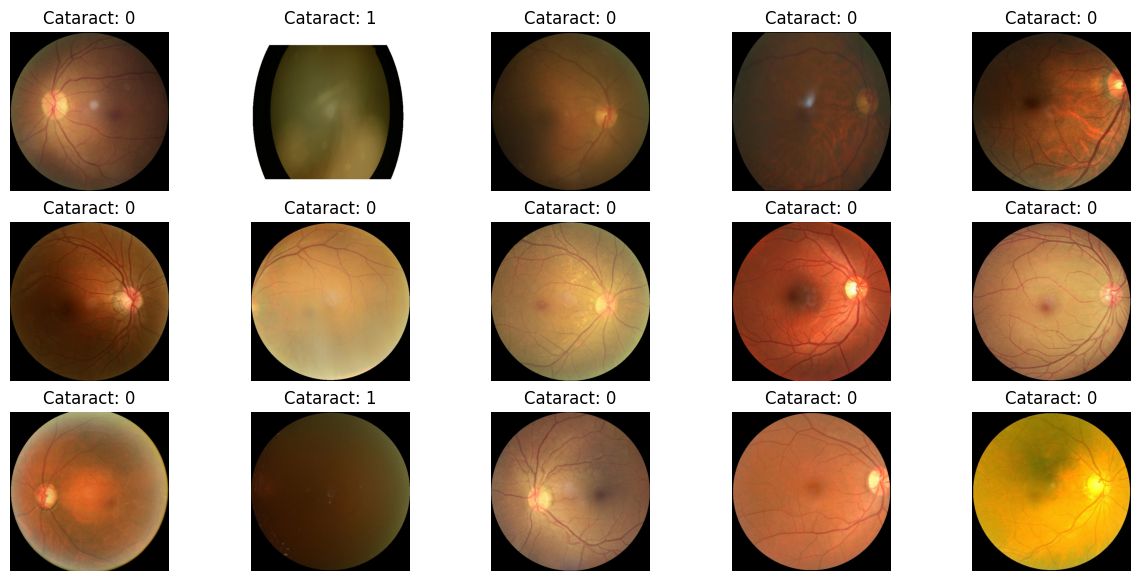

In [17]:
# Display randomly selected labeled images
fig, axs = plt.subplots(3, 5, figsize=(15,7))
axs = axs.flatten()

for ax in axs:
  img, label = rand_image()
  img = Image.open(img)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f'Cataract: {label}')

##Sample tranformations

In [18]:
list_transforms = [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                 transforms.RandomEqualize(),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.Grayscale(),
                                 transforms.RandomInvert()]

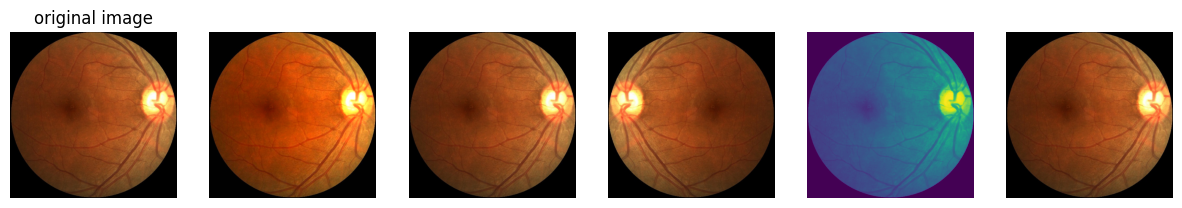

In [19]:
# Displaying an original image and its five transformations
fig, axs = plt.subplots(1,6, figsize=(15,3))
axs = axs.flatten()
img, label = rand_image()
img = Image.open(img)


for i, ax in enumerate(axs):
  axs[0].imshow(img)
  axs[0].set_title('original image')
  transf = list_transforms[i-1]
  ax = axs[i]
  ax.axis('off')
  transf_img = transf(img)
  ax.imshow(transf_img)

#Split to train, validation and test sets

In [20]:
X = df_combined.copy()
y = df_combined['label']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=6)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=6)

In [22]:
# Organizing and copying images from different sets (train, val, test) to corresponding directories based on labels.
path_dict = {'train/': X_train, 'val/': X_val, 'test/': X_test}

for key, df in path_dict.items():

  save_path = Path(key)

  for i, img in enumerate(tqdm(df.filename)):
    img_path = root_path/img

    label = df.label.iloc[i]

    img_save_path = root_path/save_path/str(label)
    img_save_path.mkdir(parents=True, exist_ok=True)

    if img_path.exists():
      shutil.copy(img_path, img_save_path)

100%|██████████| 1200/1200 [00:00<00:00, 3362.77it/s]


#Create Pytorch Data Generators

In [23]:
train_path = '/content/preprocessed_images/train'
val_path = '/content/preprocessed_images/val'
test_path = '/content/preprocessed_images/test'

In [24]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Train_dataloader will be create later

val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     normalize])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     normalize])

In [25]:
val_dataset = datasets.ImageFolder(val_path, val_transforms)
test_dataset = datasets.ImageFolder(test_path,test_transforms)

In [26]:
batch_size = 64
num_workers = 2

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [27]:
def create_dataloaders(*args, batch_size, val_loader):
  """
  Creating data loaders for training and validation sets with specified transformations and batch size
  """
  data_tranforms = transforms.Compose([*args,
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       normalize])

  train_dataset = datasets.ImageFolder(train_path, data_tranforms)
  train_loader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size = batch_size,
                                              shuffle=True,
                                              num_workers=num_workers)

  dataloaders = {'train': train_loader, 'val': val_loader}

  return dataloaders

#Model function

In [34]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

cuda


In [35]:
criterion = nn.CrossEntropyLoss()

In [36]:
def prepare_model_1(pre_trained_model, class_function=nn.Sigmoid(), learning_rate=0.001):
  """
  Prepare a first model based on a pre-trained architecture with customizable classification layer and learning rate
  """

  # Load the EfficientNet architecture
  model = timm.create_model(pre_trained_model, pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

  # Replace the last classification layer with a new layer with two outputs
  num_ftrs = model.classifier.in_features
  model.classifier = nn.Linear(num_ftrs, 2)

  # Add a function at the end
  model = nn.Sequential(model, class_function)

  model = model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  return model, optimizer

In [37]:
def prepare_model_2(pre_trained_model, class_function=nn.Sigmoid(), learning_rate=0.001):
  """
  Prepare a second model based on a pre-trained architecture with a custom fully-connected layer,
  activation functions, and learning rate
  """

  # Load the EfficientNet architecture
  model = timm.create_model(pre_trained_model, pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

  # Replace the last classification layer with a new layer with two outputs
  num_ftrs = model.classifier.in_features
  model.classifier = nn.Sequential(nn.Linear(num_ftrs, 256),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(256),
                                   nn.Dropout(0.5),
                                   nn.Linear(256, 2))

  model = nn.Sequential(model, class_function)

  model = model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  return model, optimizer

#Training function

In [28]:
def calculate_f1(precision, recall):
  """
  Calculate F1 score based on precision and recall values
  """
  F1 = 2 * precision * recall / (precision + recall)
  return F1

In [29]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=10):
    """
    Train a model with specified dataloaders, model architecture, loss criterion, optimizer, and scheduler.
    Monitor training metrics including loss, accuracy, precision, recall, and F1 score.
    Implement early stopping if validation loss does not improve for a certain number of epochs.
    """

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    best_val_loss = float('inf')
    es_patience = 10

    for epoch in tqdm(range(num_epochs)):

        metrics = {}

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            corrects = 0
            r_positives = 0
            t_positives = 0
            tf_positives = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()

                metrics[phase] = {}
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                corrects += sum(preds == labels.data)
                r_positives += sum(labels == 1).item()
                t_positives += sum((preds == labels) & (labels == 1)).item()
                tf_positives += sum(preds == 1).item()

            num_inputs = len(dataloaders[phase].dataset)
            metrics[phase]['loss'] = round(running_loss / num_inputs, 4)
            metrics[phase]['acc'] = round(corrects.item() / num_inputs, 4)
            metrics[phase]['precision'] = round(t_positives / tf_positives, 4)
            metrics[phase]['recall'] = round(t_positives / r_positives, 4)
            metrics[phase]['F1'] = round(calculate_f1(metrics[phase]['precision'], metrics[phase]['recall']), 4)

        if phase == 'train':
            scheduler.step()

        if metrics['val']['loss'] <= best_val_loss:
            best_val_loss = metrics['val']['loss']
            best_metrics = pd.DataFrame(metrics)
            best_model = model
            patience = es_patience
        else:
            patience -= 1
            if patience == 0:
                print('\n Early stopping')
                break

        if (epoch+1)%5 == 0:
            print(f'\n Epoch {epoch+1}/{num_epochs}')
            for phase in ['train', 'val']:
                print(f'{phase} loss: {metrics[phase]["loss"]:.4f}, {phase} accuracy: {metrics[phase]["acc"]:.4f}')

        train_loss_history.append(metrics['train']['loss'])
        train_accuracy_history.append(metrics['train']['acc'])
        val_loss_history.append(metrics['val']['loss'])
        val_accuracy_history.append(metrics['val']['acc'])

        train_history = [train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history]

    return best_model, best_metrics, train_history

In [30]:
def plot_learning(train_history):
  """
  This function creates a subplot with two plots (for accuracy and loss) to visualize the training and validation performance over epochs
  """
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))
  history = {'Accuracy': [train_history[0], train_history[1]], 'Loss': [train_history[2], train_history[3]]}

  for i, name in enumerate(['Accuracy', 'Loss']):
    ax = axs[i]
    ax.plot(history[name][0], label='train')
    ax.plot(history[name][1], label='validation')
    ax.set_title(name)
    ax.legend()
    ax.set_xlabel('no. of epochs')
  plt.show()

#Selecting

In [32]:
test_dataloaders = create_dataloaders(batch_size=batch_size, val_loader=val_loader)

##Selecting model type

In [38]:
model_1, optimizer_1 = prepare_model_1('efficientnet_b0')
model_2, optimizer_2 = prepare_model_2('efficientnet_b0')

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
models = {'model_1': [model_1, optimizer_1], 'model_2': [model_2, optimizer_2]}

In [ ]:
i = 0
model_scores = pd.DataFrame({'models': models.keys(),
                             'loss': np.zeros(len(models)),
                             'accuracy': np.zeros(len(models)),
                             'precision': np.zeros(len(models)),
                             'recall': np.zeros(len(models)),
                             'F1': np.zeros(len(models))})

for key, option in models.items():
  print(key)
  model = option[0]
  optimizer = option[1]
  scheduler = StepLR(optimizer, step_size=10, gamma=1)
  trained_model, metrics, history = train_model(test_dataloaders, model, criterion, optimizer, scheduler, num_epochs=20)
  print()

  for j in list(range(1,6)):
    model_scores.iloc[i,j] = metrics.iloc[j-1,1]

  i+=1

In [ ]:
#Scores for validation set
model_scores

,models,loss,accuracy,precision,recall,F1
0,model_1,0.3391,0.9758,0.8969,0.8447,0.8700
1,model_2,0.3234,0.9898,0.9600,0.9320,0.9458


##Selecting class_function

In [45]:
model_si, optimizer_si = prepare_model_2('efficientnet_b0', nn.Sigmoid())
model_sf, optimizer_sf = prepare_model_2('efficientnet_b0', nn.Softmax(dim=1))

In [ ]:
class_functions = {'Sigmoid': [model_si, optimizer_si], 'Softmax': [model_sf, optimizer_sf]}

In [ ]:
i = 0
class_scores = pd.DataFrame({'models': class_functions.keys(),
                             'loss': np.zeros(len(class_functions)),
                             'accuracy': np.zeros(len(class_functions)),
                             'precision': np.zeros(len(class_functions)),
                             'recall': np.zeros(len(class_functions)),
                             'F1': np.zeros(len(class_functions))})

for key, option in class_functions.items():
  print(key)
  model = option[0]
  optimizer = option[1]
  scheduler = StepLR(optimizer, step_size=10, gamma=1)
  trained_model, metrics, history = train_model(test_dataloaders, model, criterion, optimizer, scheduler, num_epochs=10)
  print()

  for j in list(range(1,6)):
    class_scores.iloc[i,j] = metrics.iloc[j-1,1]

  i+=1

In [ ]:
#Scores for validation set
class_scores

,models,loss,accuracy,precision,recall,F1
0,Sigmoid,0.3254,0.9888,0.9505,0.932,0.9412
1,Softmax,0.3243,0.9898,0.9600,0.932,0.9458


##Selecting transformations

In [46]:
model, optimizer = model_sf, optimizer_sf
scheduler = StepLR(optimizer_sf, step_size=10, gamma=1)

In [ ]:
transformations = {'ColorJitter': transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                   'RandomSharpness_08': transforms.RandomAdjustSharpness(sharpness_factor=0.8),
                   'RandomEqualize': transforms.RandomEqualize(),
                   'GaussianBlur_1': transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.5,2)),
                   'RandomHorizontalFlip': transforms.RandomHorizontalFlip(),
                   'RandomAffine': transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.95, 1.05)),
                   'RandomSharpness_11': transforms.RandomAdjustSharpness(sharpness_factor=1.1),
                   'RandomInvert': transforms.RandomInvert(),
                   'RandomAutocontrast': transforms.RandomAutocontrast(),
                   'RandomGrayscale': transforms.RandomGrayscale(p=0.5),
                   'GaussianBlur_2': transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,1)),
                   'RandomVerticalFlip': transforms.RandomVerticalFlip(),
                   'RandomRotation': transforms.RandomRotation(degrees=(-5, 5)),
                   'RandomCrop': transforms.RandomCrop(size=(200, 200)),
                   'RandomSharpness_12': transforms.RandomAdjustSharpness(sharpness_factor=1.2)}

In [ ]:
i = 0
transformations_scores = pd.DataFrame({'transformations': transformations.keys(),
                                       'loss': np.zeros(len(transformations)),
                                       'accuracy': np.zeros(len(transformations)),
                                       'precision': np.zeros(len(transformations)),
                                       'recall': np.zeros(len(transformations)),
                                       'F1': np.zeros(len(transformations))})

for key, transform in transformations.items():
  print(key)
  test_dataloaders = create_dataloaders(transform, batch_size=batch_size, val_loader=val_loader)
  trained_model, metrics, history = train_model(test_dataloaders, model, criterion, optimizer, scheduler, num_epochs=5)
  print()

  for j in list(range(1,6)):
    transformations_scores.iloc[i,j] = metrics.iloc[j-1,1]

  i+=1

In [ ]:
#Scores for validation set
transformations_scores

,transformations,loss,accuracy,precision,recall,F1
0,ColorJitter,0.3272,0.9860,0.9400,0.9126,0.9261
1,RandomSharpness_08,0.3249,0.9888,0.9596,0.9223,0.9406
2,RandomEqualize,0.3284,0.9842,0.9479,0.8835,0.9146
3,GaussianBlur_1,0.3240,0.9907,0.9697,0.9320,0.9505
4,RandomHorizontalFlip,0.3225,0.9907,0.9515,0.9515,0.9515
5,RandomAffine,0.3236,0.9898,0.9510,0.9417,0.9463
6,RandomSharpness_11,0.3221,0.9916,0.9700,0.9417,0.9556
7,RandomInvert,0.3287,0.9851,0.9307,0.9126,0.9216
8,RandomAutocontrast,0.3234,0.9898,0.9600,0.9320,0.9458
9,RandomGrayscale,0.3284,0.9833,0.9293,0.8932,0.9109


In [41]:
selected_transforms = transforms.RandomChoice([transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.5,2)),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.95, 1.05)),
                                               transforms.RandomAdjustSharpness(sharpness_factor=1.1),
                                               transforms.RandomAutocontrast(),
                                               transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,1)),
                                               transforms.RandomVerticalFlip(),
                                               transforms.RandomRotation(degrees=(-5, 5)),
                                               transforms.RandomAdjustSharpness(sharpness_factor=1.2)])

## Selecting train batch size

In [ ]:
batch_size_list = [2, 4, 16, 32, 64, 128]

In [ ]:
batch_scores = pd.DataFrame({'batch_size': batch_size_list,
                             'loss': np.zeros(len(batch_size_list)),
                             'accuracy': np.zeros(len(batch_size_list)),
                             'precision': np.zeros(len(batch_size_list)),
                             'recall': np.zeros(len(batch_size_list)),
                             'F1': np.zeros(len(batch_size_list))})

for i, test_batch_size in enumerate(batch_size_list):
  print(f'Batch_size: {test_batch_size}')
  dataloaders = create_dataloaders(selected_transforms, batch_size=test_batch_size, val_loader=val_loader)
  trained_model, metrics, history = train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=10)
  print()

  for j in list(range(1,6)):
    batch_scores.iloc[i,j] = metrics.iloc[j-1,1]

In [ ]:
#Scores for validation set
batch_scores

,batch_size,loss,accuracy,precision,recall,F1
0,2,0.4607,0.8409,0.3731,0.9709,0.5391
1,4,0.3591,0.9544,0.6875,0.9612,0.8016
2,16,0.3320,0.9823,0.8818,0.9417,0.9108
3,32,0.3274,0.9870,0.9159,0.9515,0.9334
4,64,0.3258,0.9888,0.9417,0.9417,0.9417
5,128,0.3252,0.9879,0.9327,0.9417,0.9372


In [ ]:
batch_size = 64

In [ ]:
dataloaders = create_dataloaders(selected_transforms, batch_size=batch_size, val_loader=val_loader)

##Selecting learning rate sheduler

In [113]:
num_epochs = 10
total_steps = len(dataloaders['train'])*num_epochs

In [114]:
st_scheduler = StepLR(optimizer, step_size=total_steps, gamma=1)

exp_scheduler = ExponentialLR(optimizer, gamma=0.9)

cos_scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0.0001)

oc_cos_scheduler = OneCycleLR(optimizer, max_lr=0.001,
                              total_steps=total_steps,
                              epochs=num_epochs,
                              anneal_strategy='cos')

oc_lin_scheduler = OneCycleLR(optimizer,
                              max_lr=0.001,
                              total_steps=total_steps,
                              epochs=num_epochs,
                              anneal_strategy="linear")

In [ ]:
schedulers = {'exp_scheduler': exp_scheduler}

In [ ]:
schedulers = {'st_scheduler': st_scheduler,
              'exp_scheduler': exp_scheduler,
              'cos_scheduler': cos_scheduler,
              'oc_cos_scheduler': oc_cos_scheduler,
              'oc_lin_scheduler': oc_lin_scheduler}

In [ ]:
dataloaders = create_dataloaders(selected_transforms, batch_size=batch_size, val_loader=val_loader)

scheduler_scores = pd.DataFrame({'scheduler': schedulers.keys(),
                             'loss': np.zeros(len(schedulers)),
                             'accuracy': np.zeros(len(schedulers)),
                             'precision': np.zeros(len(schedulers)),
                             'recall': np.zeros(len(schedulers)),
                             'F1': np.zeros(len(schedulers))})

i=0
for key, scheduler in schedulers.items():
  print(f'scheduler: {key}')
  model, optimizer = prepare_model_2('efficientnet_b0', class_function=nn.Softmax(dim=1), learning_rate=0.001)
  trained_model, metrics, history = train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=num_epochs)
  print()

  for j in list(range(1,6)):
    scheduler_scores.iloc[i,j] = metrics.iloc[j-1,1]

  i+=1

In [ ]:
scheduler_scores

,scheduler,loss,accuracy,precision,recall,F1
0,st_scheduler,0.3245,0.9879,0.9500,0.9223,0.9359
1,exp_scheduler,0.3245,0.9879,0.9500,0.9223,0.9359
2,cos_scheduler,0.3243,0.9888,0.9505,0.9320,0.9412
3,oc_cos_scheduler,0.3244,0.9888,0.9596,0.9223,0.9406
4,oc_lin_scheduler,0.3216,0.9916,0.9608,0.9515,0.9561


#Training model

In [39]:
efficientnet_models = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3']

In [47]:
num_epochs = 50
dataloaders = create_dataloaders(selected_transforms, batch_size=batch_size, val_loader=val_loader)
total_steps = len(dataloaders['train'])*num_epochs
scheduler = OneCycleLR(optimizer,
                       max_lr=0.001,
                       total_steps=total_steps,
                       epochs=num_epochs,
                       anneal_strategy="linear")

efficientnet_b0


 10%|█         | 5/50 [02:54<26:06, 34.82s/it]


 Epoch 5/50
train loss: 0.3424, train accuracy: 0.9718
val loss: 0.3351, val accuracy: 0.9795


 20%|██        | 10/50 [05:43<22:30, 33.77s/it]


 Epoch 10/50
train loss: 0.3336, train accuracy: 0.9808
val loss: 0.3293, val accuracy: 0.9823


 30%|███       | 15/50 [08:32<19:41, 33.77s/it]


 Epoch 15/50
train loss: 0.3292, train accuracy: 0.9836
val loss: 0.3261, val accuracy: 0.9879


 40%|████      | 20/50 [11:23<17:06, 34.21s/it]


 Epoch 20/50
train loss: 0.3298, train accuracy: 0.9836
val loss: 0.3243, val accuracy: 0.9888


 50%|█████     | 25/50 [14:11<14:09, 33.96s/it]


 Epoch 25/50
train loss: 0.3286, train accuracy: 0.9851
val loss: 0.3267, val accuracy: 0.9860


 60%|██████    | 30/50 [17:05<11:31, 34.57s/it]


 Epoch 30/50
train loss: 0.3262, train accuracy: 0.9867
val loss: 0.3243, val accuracy: 0.9888


 70%|███████   | 35/50 [20:02<08:48, 35.23s/it]


 Epoch 35/50
train loss: 0.3250, train accuracy: 0.9883
val loss: 0.3243, val accuracy: 0.9898


 80%|████████  | 40/50 [22:50<05:39, 33.99s/it]


 Epoch 40/50
train loss: 0.3276, train accuracy: 0.9851
val loss: 0.3226, val accuracy: 0.9907


 90%|█████████ | 45/50 [25:41<02:51, 34.26s/it]


 Epoch 45/50
train loss: 0.3252, train accuracy: 0.9886
val loss: 0.3252, val accuracy: 0.9870


 92%|█████████▏| 46/50 [26:50<02:20, 35.01s/it]


 Early stopping


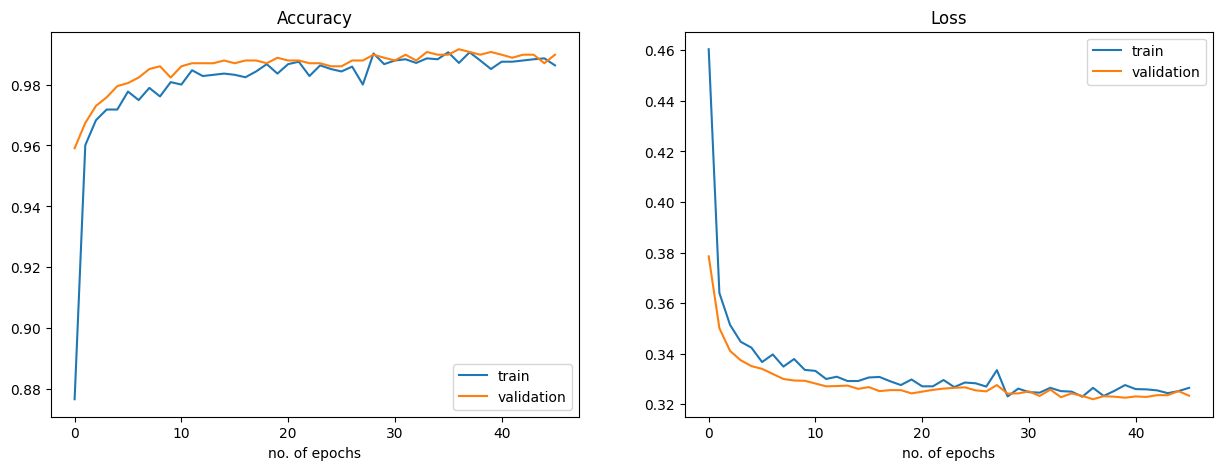


efficientnet_b1


model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

 10%|█         | 5/50 [02:55<26:06, 34.82s/it]


 Epoch 5/50
train loss: 0.3374, train accuracy: 0.9789
val loss: 0.3340, val accuracy: 0.9805


 20%|██        | 10/50 [05:48<23:11, 34.78s/it]


 Epoch 10/50
train loss: 0.3351, train accuracy: 0.9792
val loss: 0.3292, val accuracy: 0.9851


 30%|███       | 15/50 [08:39<19:45, 33.89s/it]


 Epoch 15/50
train loss: 0.3320, train accuracy: 0.9808
val loss: 0.3259, val accuracy: 0.9870


 40%|████      | 20/50 [11:31<17:12, 34.42s/it]


 Epoch 20/50
train loss: 0.3294, train accuracy: 0.9836
val loss: 0.3242, val accuracy: 0.9898


 50%|█████     | 25/50 [14:21<14:18, 34.35s/it]


 Epoch 25/50
train loss: 0.3272, train accuracy: 0.9863
val loss: 0.3231, val accuracy: 0.9888


 60%|██████    | 30/50 [17:13<11:26, 34.31s/it]


 Epoch 30/50
train loss: 0.3254, train accuracy: 0.9875
val loss: 0.3195, val accuracy: 0.9944


 70%|███████   | 35/50 [20:05<08:40, 34.71s/it]


 Epoch 35/50
train loss: 0.3250, train accuracy: 0.9883
val loss: 0.3223, val accuracy: 0.9907


 76%|███████▌  | 38/50 [22:23<07:04, 35.35s/it]


 Early stopping


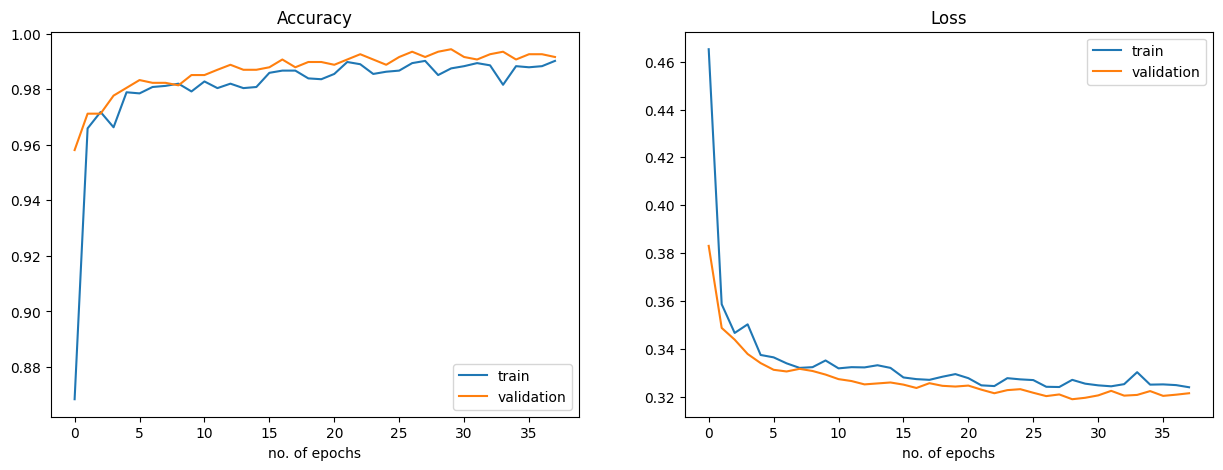


efficientnet_b2


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

 10%|█         | 5/50 [02:54<26:11, 34.92s/it]


 Epoch 5/50
train loss: 0.3440, train accuracy: 0.9718
val loss: 0.3372, val accuracy: 0.9758


 20%|██        | 10/50 [05:46<22:57, 34.43s/it]


 Epoch 10/50
train loss: 0.3382, train accuracy: 0.9757
val loss: 0.3337, val accuracy: 0.9795


 30%|███       | 15/50 [08:43<20:25, 35.01s/it]


 Epoch 15/50
train loss: 0.3304, train accuracy: 0.9832
val loss: 0.3295, val accuracy: 0.9842


 40%|████      | 20/50 [11:39<17:34, 35.16s/it]


 Epoch 20/50
train loss: 0.3300, train accuracy: 0.9832
val loss: 0.3273, val accuracy: 0.9870


 50%|█████     | 25/50 [14:32<14:31, 34.88s/it]


 Epoch 25/50
train loss: 0.3242, train accuracy: 0.9886
val loss: 0.3277, val accuracy: 0.9851


 60%|██████    | 30/50 [17:24<11:28, 34.41s/it]


 Epoch 30/50
train loss: 0.3272, train accuracy: 0.9855
val loss: 0.3267, val accuracy: 0.9860


 70%|███████   | 35/50 [20:18<08:40, 34.67s/it]


 Epoch 35/50
train loss: 0.3283, train accuracy: 0.9855
val loss: 0.3278, val accuracy: 0.9851


 80%|████████  | 40/50 [23:20<06:16, 37.70s/it]


 Epoch 40/50
train loss: 0.3270, train accuracy: 0.9867
val loss: 0.3260, val accuracy: 0.9870


 80%|████████  | 40/50 [23:58<05:59, 35.95s/it]


 Early stopping


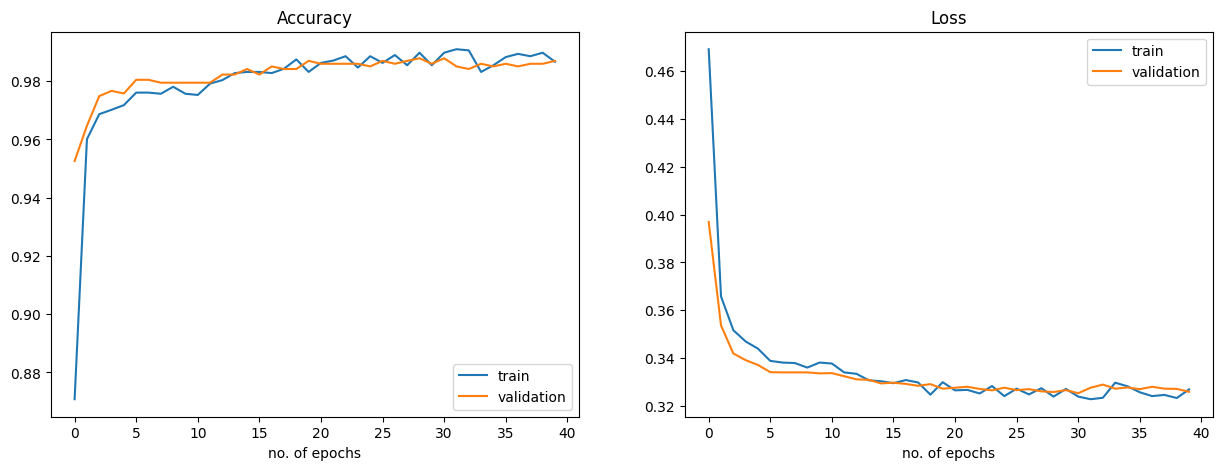


efficientnet_b3


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

 10%|█         | 5/50 [03:06<27:31, 36.69s/it]


 Epoch 5/50
train loss: 0.3450, train accuracy: 0.9706
val loss: 0.3374, val accuracy: 0.9777


 20%|██        | 10/50 [06:15<25:23, 38.09s/it]


 Epoch 10/50
train loss: 0.3336, train accuracy: 0.9792
val loss: 0.3294, val accuracy: 0.9851


 30%|███       | 15/50 [09:36<23:33, 40.37s/it]


 Epoch 15/50
train loss: 0.3311, train accuracy: 0.9836
val loss: 0.3279, val accuracy: 0.9860


 40%|████      | 20/50 [12:50<19:29, 38.98s/it]


 Epoch 20/50
train loss: 0.3293, train accuracy: 0.9839
val loss: 0.3224, val accuracy: 0.9907


 50%|█████     | 25/50 [15:52<15:12, 36.50s/it]


 Epoch 25/50
train loss: 0.3265, train accuracy: 0.9859
val loss: 0.3248, val accuracy: 0.9879


 58%|█████▊    | 29/50 [18:58<13:44, 39.26s/it]


 Early stopping


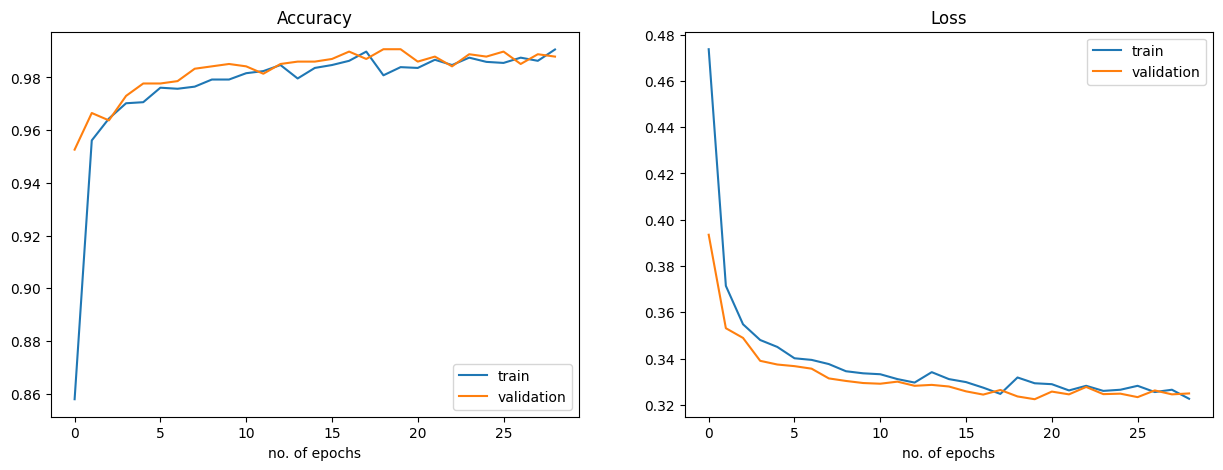

loss     acc  precision  recall      F1
efficientnet_b0 train  0.3265  0.9871     0.9323  0.9360  0.9341
                val    0.3220  0.9916     0.9608  0.9515  0.9561
efficientnet_b1 train  0.3270  0.9851     0.9240  0.9240  0.9240
                val    0.3189  0.9935     0.9800  0.9515  0.9655
efficientnet_b2 train  0.3240  0.9898     0.9553  0.9400  0.9476
                val    0.3254  0.9879     0.9688  0.9029  0.9347
efficientnet_b3 train  0.3293  0.9839     0.9485  0.8840  0.9151
                val    0.3224  0.9907     0.9604  0.9417  0.9510

In [48]:
saved_path = Path('/content/drive/MyDrive/Colab Notebooks/Saved Models/Cataract_Classification')
results = {}

for i, efficientnet in enumerate(efficientnet_models):

  print(efficientnet)

  model, optimizer = prepare_model_2(efficientnet, nn.Softmax(dim=1), learning_rate=0.001)
  best_model, best_metrics, train_history = train_model(dataloaders, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler, num_epochs=num_epochs)

  plot_learning(train_history)
  print()

  results[efficientnet] = best_metrics.T

  model_file = 'best_model_' + efficientnet +'.pt'
  torch.save(model.state_dict(), saved_path/model_file)

results = pd.concat(results.values(), keys=results.keys())
results

#Prediction

In [61]:
def test_model(dataloader, model, criterion):

  metrics = {}
  corrects = 0
  r_positives = 0
  t_positives = 0
  tf_positives = 0
  probabilities = []

  model.eval()

  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    probabilities.append(outputs)

    _, preds = torch.max(outputs, 1)
    corrects += sum(preds == labels.data)
    r_positives += sum(labels == 1).item()
    t_positives += sum((preds == labels) & (labels == 1)).item()
    tf_positives += sum(preds == 1).item()

  num_inputs = len(dataloader.dataset)
  metrics['accuracy'] = round(corrects.item() / num_inputs, 4)
  metrics['precision'] = round(t_positives / tf_positives, 4)
  metrics['recall'] = round(t_positives / r_positives, 4)
  metrics['F1'] = round(calculate_f1(metrics['precision'], metrics['recall']), 4)

  probabilities = torch.cat(probabilities, dim=0)

  return probabilities, metrics

In [81]:
def predict_average_model(dataloader):

    results = {}
    all_probabilities = []
    dataset = dataloader.dataset
    labels = torch.tensor(dataset.targets).to(device)

    for i, efficientnet in enumerate(efficientnet_models):

      model_file = 'best_model_' + efficientnet +'.pt'
      model, optimizer = prepare_model_2(efficientnet, nn.Softmax(dim=1), learning_rate=0.001)
      model.load_state_dict(torch.load(saved_path/model_file))

      probabilities, metrics = test_model(dataloader, model, criterion)

      all_probabilities.append(probabilities)
      results[efficientnet] = metrics

    all_probabilities = torch.stack(all_probabilities)
    averaged_probabilities = torch.mean(all_probabilities, dim=0)

    _, preds = torch.max(averaged_probabilities, 1)
    corrects = sum(preds == labels).item()
    r_positives = sum(labels == 1).item()
    t_positives = sum((preds == labels) & (labels == 1)).item()
    tf_positives = sum(preds == 1).item()

    avg_metrics = {}
    num_inputs = len(dataset)
    avg_metrics['accuracy'] = round(corrects / num_inputs, 4)
    avg_metrics['precision'] = round(t_positives / tf_positives, 4)
    avg_metrics['recall'] = round(t_positives / r_positives, 4)
    avg_metrics['F1'] = round(calculate_f1(metrics['precision'], metrics['recall']), 4)

    results['avarage_model'] = avg_metrics
    results = pd.DataFrame(results)

    return results, preds

In [82]:
test_results, test_preds = predict_average_model(test_loader)
test_results

,efficientnet_b0,efficientnet_b1,efficientnet_b2,efficientnet_b3,avarage_model
accuracy,0.9899,0.9872,0.9918,0.9899,0.9918
precision,0.9804,0.9524,0.9902,0.9712,0.9808
recall,0.9174,0.9174,0.9266,0.9266,0.9358
F1,0.9479,0.9346,0.9573,0.9484,0.9484


#Sample preditions

In [ ]:
torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [108]:
rand_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)

In [109]:
batch = next(iter(rand_test_loader))
imgs, labs = batch

In [ ]:
temp_dataloader = DataLoader([batch], batch_size=1, shuffle=False)

# Wywołanie funkcji predict_average_model na danym batchu
results_df, preds = predict_average_model(temp_dataloader)

In [ ]:

_, pred_labels = predict_average_model([batch])
fig, axs = plt.subplots(1, 5, figsize=(15,7))
axs = axs.flatten()


for i, (img, label) in enumerate(batch):
  img = Image.open(img)
  pred_label = pred_labels[i]
  ax[i].imshow(img)
  ax[i].axis('off')
  ax[i].set_title(f'Cataract: {label} \n Prediction: {pred_label}')

In [ ]:
img_label_list = [rand_image('test') for i in range(4)]
img_list = [img_label_list[i][0] for i in range(4)]
label_list = [img_label_list[i][1] for i in range(4)]

In [ ]:
test_batch = torch.stack([data_transforms(img).to(device) for img in img_list])

pred_logits_tensor = best_model(test_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()*100

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))

for i, img in enumerate(img_list):
  ax = axs[i]
  ax.axis('off')
  ax.set_title(f'{label_list[i]} \n alien: {pred_probs[i,0]:.0f}%, predator: {pred_probs[i,1]:.0f}%')
  ax.imshow(img)